In [1]:
#Basic imports
import sys
import random
import collections

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import seaborn as sns
#import statsmodels.api as sm
import scikits.bootstrap as bs

DATA_DIR = "/dfs/scratch0/googlengrams/2012-eng-fic/"
sys.path.append("../langchange")

import ioutils as util
from cooccurrence import matstore
from statutils import plothelper, changepoint, trendestimator, seriesanalysis, mixedmodels
from vecanalysis.sequentialexplicit import SequentialExplicit

%matplotlib inline

In [2]:
# Loading basic word and frequency info
year_words = util.load_pickle(DATA_DIR + "/info/freqnonstop_peryear-1900-2000-7.pkl")
years = np.arange(1900, 2001)
freqs = util.load_pickle(DATA_DIR + "/info/freqnonstop_peryear-1900-2000-7-freqs.pkl")
# top year words contains only top 20000 words per year
top_year_words = {}
for year, words in year_words.iteritems():
    top_year_words[year] = words[:10000]
all_words = set([word for year_words in top_year_words.values() for word in year_words])
year_freqs = collections.defaultdict(lambda : collections.defaultdict(lambda : float('nan')))
for year, words in top_year_words.iteritems():
    for word in words:
        year_freqs[word][year] = freqs[word][year]

# Load word lists
brown = util.load_word_list(MISC_DIR + "/brownwords.txt")
concrete = util.load_word_list(MISC_DIR + "/concretewords.txt")
abstract = util.load_word_list(MISC_DIR "/abstractwords.txt")
concrete_cmn = util.load_word_list(MISC_DIR + "/concretewords-cmn.txt")
abs_cmn = util.load_word_list(MISC_DIR + "/abstractwords-cmn.txt")
nouns = util.load_word_list(MISC_DIR + "/nouns.txt")
adjs = util.load_word_list(MISC_DIR + "/adjs.txt")
verbs = util.load_word_list(MISC_DIR + "/misc/verbs.txt")
advs = util.load_word_list(MISC_DIR + "/advs.txt")

In [3]:
# loading stats
# sums = magnitude, clusts = - polysemy, vols = rate of change, cents = centrality, knn_sums = sim. with nearest neighbours
sums = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/netstats/freqnonstop_peryear-1900-2000-7-top20000-sum.pkl")
clusts = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/netstats/freqnonstop_peryear-1900-2000-7-top20000-weighted.pkl")
vols =  util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/volstats/freqnonstop_peryear-1900-2000-7-0.0-top20000-vols.pkl")
cents = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/secondnetstats-0-None/freqnonstop_peryear-1900-2000-7-top20000-sum.pkl")
knn_sums = util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/secondnetstats-0-5/freqnonstop_peryear-1900-2000-7-top20000-sum.pkl")
disps =  util.load_pickle(DATA_DIR + "/nppmi_conf/lsmooth10/volstats/freqnonstop_peryear-1900-2000-7-0.0-top20000-disps.pkl")

In [4]:
# log transform of variables as necessary
log_freqs = {word:{year:np.log(freq) for year, freq in vals.iteritems()} for word, vals in freqs.iteritems()}
log_sums = {word:{year:np.log(sum) for year, sum in vals.iteritems()} for word, vals in sums.iteritems()}
log_clusts = {word:{year:np.log(clust) for year, clust in vals.iteritems()} for word, vals in clusts.iteritems()}
log_cents = {word:{year:np.log(cent) for year, cent in vals.iteritems()} for word, vals in cents.iteritems()}

In [5]:
# get concreteness score
import dill
con_scores = dill.load(open(DATA_DIR + "/nppmi_conf/lsmooth10/netstats/conscores-10.pkl", "r"))
con_scores_ms = seriesanalysis.get_series_mean_std(con_scores, con_scores.keys())

In [12]:
# medians of variables as necessary
log_freqs_med = seriesanalysis.get_series_mean_std_peryear(log_freqs, top_year_words)[0]
log_sums_med = seriesanalysis.get_series_mean_std_peryear(log_sums, top_year_words)[0]
log_clusts_med = seriesanalysis.get_series_mean_std_peryear(log_clusts, top_year_words)[0]
log_cents_med = seriesanalysis.get_series_mean_std_peryear(log_cents, top_year_words)[0]

In [13]:
# setting up dataframe
random.seed(10)
# keep words that have valid volatility scores and second order centralities
valid_set = (set(vols.keys()).intersection(set(cents.keys()))).intersection(set(brown))
verb_set = set(verbs)
adj_set = set(adjs)
adv_set = set(advs)
con_set = set(concrete)
abs_set = set(abstract)
valid_list = list(valid_set)
random.shuffle(valid_list)
# 500 words for validation, 500 for testing
feature_dict = {"freq" : (lambda word, year : log_freqs[word][year-1] - log_freqs_med[year-1901]),
                "freq_diff" : (lambda word, year : abs(log_freqs[word][year] - log_freqs_med[year-1900] - log_freqs[word][year-1] + log_freqs_med[year-1901])),
                "extent" : (lambda word, year : log_sums[word][year-1] - log_sums_med[year-1901]),
                "centr" : (lambda word, year : log_cents[word][year-1] - log_cents_med[year-1901]),
                "clust" : (lambda word, year : log_clusts[word][year-1] - log_clusts_med[year-1901]),
                "con" : (lambda word, year : (con_scores[word][year-1] -  con_scores_ms[0][year-1901]) / (con_scores_ms[1][year-1901])),
                "vol" : (lambda word, year : (1 - vols[word][year])),
                "disp" : (lambda word, year : (1 - disps[word][year-1])),
              #  "lag_vol" : (lambda word, year : (1 - vols[word][year-1])), no lagged vol unless really necessary
                }
temp_df = mixedmodels.make_data_frame(valid_list, range(1902, 2000), feature_dict)

In [14]:
# making train, dev, test split
kept_words = temp_df["word"].unique()
num_valtest = int((len(kept_words)) * 0.1)
test_df = temp_df.loc[temp_df["word"].isin(kept_words[:num_valtest])]
dev_df = temp_df.loc[temp_df["word"].isin(kept_words[num_valtest:2*num_valtest])]
train_df = temp_df.loc[temp_df["word"].isin(kept_words[2*num_valtest:])]

In [15]:
# helper function to make matrices out of data frame
def make_mats(df, features, target, year):
    X = (df[(df["year"] == year)])[features].as_matrix()
    Y = (df[(df["year"] == year)])[[target]].as_matrix().flatten()
    return X, Y

In [16]:
# make predictions for each year on test set (with values derived via dev set experimentation)
from sklearn.ensemble import RandomForestRegressor
random.seed(10)
years = range(1950, 2000)
mod_trees = collections.defaultdict(dict)
vol_trees = collections.defaultdict(dict)
full_trees = collections.defaultdict(dict)
mean_mse = {}
mean_errs = {}
for year in years:
    X, y = make_mats(train_df, ["freq", "freq_diff", "extent", "centr", "clust", "con"], "disp", year)
    X_t, y_t = make_mats(test_df, ["freq", "freq_diff", "extent", "centr", "clust", "con"], "disp", year)
    mod = RandomForestRegressor(n_estimators=100, min_samples_split=50)
    mod.fit(X, y)
    mod_trees["fit"][year] = mod
    mod_trees["mse"][year] = np.mean((mod.predict(X_t) - y_t) ** 2.0)
    mod_trees["tau"][year] = sp.stats.kendalltau(mod.predict(X_t), y_t)
    mod_trees["errs"][year] = (mod.predict(X_t) - y_t) ** 2.0

    
    X, y = make_mats(train_df, ["vol"], "disp", year)
    X_t, y_t = make_mats(test_df, ["vol"], "disp", year)
    mod = RandomForestRegressor(n_estimators=100, min_samples_split=50)
    mod.fit(X, y)
    vol_trees["fit"][year] = mod
    vol_trees["mse"][year] = np.mean((mod.predict(X_t) - y_t) ** 2.0)
    vol_trees["tau"][year] = sp.stats.kendalltau(mod.predict(X_t), y_t)
    vol_trees["errs"][year] = (mod.predict(X_t) - y_t) ** 2.0
    
    X, y = make_mats(train_df, ["freq", "freq_diff", "extent", "centr", "clust", "con", "vol"], "disp", year)
    X_t, y_t = make_mats(test_df, ["freq", "freq_diff", "extent", "centr", "clust", "con", "vol"], "disp", year)
    mod = RandomForestRegressor(n_estimators=100, min_samples_split=50)
    mod.fit(X, y)
    full_trees["fit"][year] = mod
    full_trees["mse"][year] = np.mean((mod.predict(X_t) - y_t) ** 2.0)
    full_trees["tau"][year] = sp.stats.kendalltau(mod.predict(X_t), y_t)
    full_trees["errs"][year] = (mod.predict(X_t) - y_t) ** 2.0
    
    mean_mse[year] = np.mean((y.mean() - y_t) ** 2.0)
    mean_errs[year] = (y.mean() - y_t) ** 2.0

In [453]:
mean_perrs = {}
for year in range(1950,2000):
    X_t, y_t = make_mats(test_df, ["freq", "freq_diff", "extent", "centr", "clust", "con"], "disp", year)
    mod_trees["perrs"][year] = np.sqrt(mod_trees["errs"][year])
    full_trees["perrs"][year] = np.sqrt(full_trees["errs"][year])
    vol_trees["perrs"][year] = np.sqrt(vol_trees["errs"][year])
    mean_perrs[year] = np.sqrt(mean_errs[year])

In [468]:
X_t, y_t = make_mats(test_df, ["freq", "freq_diff", "extent", "centr", "clust", "con"], "disp", 1950)
np.mean(y_t)

0.54629999765300552

In [17]:
# helper function to get ci's per year (and dealing with fact that years might have diff # prediction words)
def get_yearly_error_cis(errs, alpha, reverse=True):
    errs = errs.values()
   # if reverse:
      #  errs.reverse()
    means = []
    lowers = []
    uppers = []
    for i, err_arr in enumerate(errs):
        _, y_t = make_mats(test_df, ["freq"], "disp", 1950+i)  
        base = np.mean(y_t)
        means.append(np.mean(err_arr))#/base)
        low, high = bs.ci(err_arr, alpha=alpha)
        lowers.append(low)#/base)
        uppers.append(high)#/base)
    return means, lowers, uppers

In [80]:
plt.rcParams["lines.linewidth"] = 0.25
plt.rcParams["patch.linewidth"] = 0.25
plt.rcParams["grid.linewidth"] = 0.6
plt.rcParams["axes.linewidth"] = 0.6
plt.rcParams["axes.labelsize"] =  7
plt.rcParams["axes.titlesize"] = 7
plt.rcParams["xtick.labelsize"] = 5
plt.rcParams["ytick.labelsize"] = 5
plt.rcParams["ytick.major.size"] = 0.4
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.size"] = 0.5
plt.rcParams["xtick.major.width"] = 0.4
plt.rcParams["ytick.minor.size"] = 0.25
plt.rcParams["ytick.minor.width"] = 0.25
plt.rcParams["legend.fontsize"] = 7
sns.set_style("ticks")


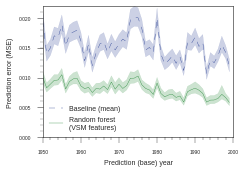

In [74]:
# Make figure 4
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
sns.set_style("ticks")
#sns.set_context("paper")
sns.set_palette("dark")
plt.rcParams["figure.figsize"] = (3.5, 2.5)
xs = range(1950, 2000)
_, ax = plt.subplots(1,1)
#base_info = get_yearly_error_cis(mean_errs, 0.05, reverse=False)
plt.plot(xs, base_info[0], color=sns.color_palette()[0], lw=0.3, ls='--')
plt.fill_between(xs, base_info[1], base_info[2], color=sns.color_palette()[0], alpha=0.2)
#mod_info = get_yearly_error_cis(mod_trees["errs"], 0.05)
plt.plot(xs, mod_info[0], color=sns.color_palette()[1], lw=0.3, ls='-')
plt.fill_between(xs, mod_info[1], mod_info[2], color=sns.color_palette()[1], alpha=0.2)
#vol_info = get_yearly_error_cis(vol_trees["errs"], 0.05)
#plt.plot(xs, vol_info[0], color=sns.color_palette()[2], lw=1, ls=':')
#plt.fill_between(xs, vol_info[1], vol_info[2], color=sns.color_palette()[2], alpha=0.2)
#full_info = get_yearly_error_cis(full_trees["errs"], 0.05, reverse=False)
#plt.plot(xs, full_info[0], color=sns.color_palette()[1], lw=1, ls='-')
#plt.fill_between(xs, full_info[1], full_info[2], color=sns.color_palette()[1], alpha=0.2)
ax.legend(["Baseline (mean)", "Random forest \n(VSM features)"], "lower left", ncol=1)
ax.set_xlabel("Prediction (base) year")
ax.set_ylabel("Prediction error (MSE)")
#a = plt.axes([.655, .132, .18, .17])
ax.set_ylim(0, 0.022)
#ax.axhspan(0.005, 0.017, xmin=0.79, xmax=0.81, fill=False, color="black", alpha=0.5, lw=1, visible=True)
#make_bplot_comp(1965, a)
#a.set_ylabel("")
#a.set_xticklabels([])
#a.set_yticklabels([])
#mark_inset(a, ax,0, 0, fc="none", ec="0.5")
plt.tight_layout()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.6)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.minorticks_on()
plt.savefig("pred-time.pdf")

In [553]:
(np.mean(base_info[0]) - np.mean(mod_info[0])) / (np.mean(base_info[0]))

0.26219543883025515

In [46]:
1 - (np.mean(mod_info[0])) / (np.mean(base_info[0]))

0.47210634233359527

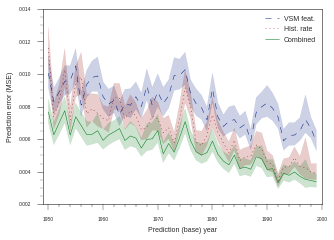

In [81]:
# make part 1 of Extended Data Figure 4
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

#sns.set_style("white")
#sns.set_context("paper")
sns.set_palette("dark")
plt.rcParams["figure.figsize"] = (5, 3.5)
xs = range(1950, 2000)
_, ax = plt.subplots(1,1)
#base_info = get_yearly_error_cis(mean_errs, 0.05, reverse=False)
#plt.plot(xs, base_info[0], color=sns.color_palette()[0], lw=1, ls='--')
#plt.fill_between(xs, base_info[1], base_info[2], color=sns.color_palette()[0], alpha=0.2)
#full_info = get_yearly_error_cis(full_trees["errs"], 0.05, reverse=False)
#mod_info = get_yearly_error_cis(mod_trees["errs"], 0.05)
plt.plot(xs, mod_info[0], color=sns.color_palette()[0], lw=0.5, ls='--')
plt.fill_between(xs, mod_info[1], mod_info[2], color=sns.color_palette()[0], alpha=0.2)
#vol_info = get_yearly_error_cis(vol_trees["errs"], 0.05)
plt.plot(xs, vol_info[0], color=sns.color_palette()[2], lw=0.5, ls=':')
plt.fill_between(xs, vol_info[1], vol_info[2], color=sns.color_palette()[2], alpha=0.2)
plt.plot(xs, full_info[0], color=sns.color_palette()[1], lw=0.5, ls='-')
plt.fill_between(xs, full_info[1], full_info[2], color=sns.color_palette()[1], alpha=0.2)
ax.legend(["VSM feat.", "Hist. rate", "Combined"], loc='upper right', ncol=1)
ax.set_xlabel("Prediction (base) year")
ax.set_ylabel("Prediction error (MSE)")
ax.set_xlim(1949, 2000)
#a = plt.axes([.655, .132, .18, .17])
#ax.set_ylim(0, 0.02)
#ax.axhspan(0.005, 0.017, xmin=0.79, xmax=0.81, fill=False, color="black", alpha=0.5, lw=1, visible=True)
#make_bplot_comp(1965, a)
#a.set_ylabel("")
#a.set_xticklabels([])
#a.set_yticklabels([])
#mark_inset(a, ax,0, 0, fc="none", ec="0.5")
#plt.tight_layout()
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.6)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.minorticks_on()
plt.savefig("ext-pred-time.pdf")

In [62]:
# test specific year to see if improvement significant
sp.stats.mannwhitneyu(vol_trees["errs"][1950], mod_trees["errs"][1950])

(528027.0, 0.000271013075710368)

In [60]:
# test aggregating over years to see if improvement significant
sp.stats.mannwhitneyu([err for errs in vol_trees["errs"].values() for err in errs], [err for errs in full_trees["errs"].values() for err in errs])

(1354303729.0, 1.3572596519585135e-101)

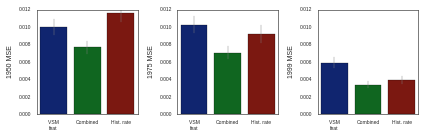

In [76]:
# Make part 2 of extended data figure 4
#sns.set_context("paper", font_scale=1)
#sns.set_palette("Set2")
sns.set_style("white")
plt.rcParams["lines.linewidth"] = 0.25
plt.rcParams["patch.linewidth"] = 0.25
plt.rcParams["grid.linewidth"] = 0.6
plt.rcParams["axes.linewidth"] = 0.6
plt.rcParams["axes.labelsize"] =  7
plt.rcParams["axes.titlesize"] = 7
plt.rcParams["xtick.labelsize"] = 5
plt.rcParams["ytick.labelsize"] = 5
plt.rcParams["figure.figsize"] = (6, 2)
fig, axs = plt.subplots(1,3)
def make_year_df(year):
    temp_df = pd.DataFrame()
    temp_df["VSM \nfeat"] = mod_trees["errs"][year]
    temp_df["Combined"] = full_trees["errs"][year] 
    temp_df["Hist. rate"] = vol_trees["errs"][year]
    return temp_df

temp_df = make_year_df(1950)
ax = sns.barplot(data=temp_df, ax=axs[0], errcolor='gray', lw=0.25, error_kw={"elinewidth":0.1, "capsize":10})
   # ax.set_ylabel("{}-year prediction error (MSE)".format(year))
y_max = np.mean(vol_trees["errs"][1950]) + 0.0012
y_min = 0.0

temp_df = make_year_df(1975)
ax = sns.barplot(data=temp_df, ax=axs[1], errcolor='gray', lw=0.25, error_kw={"elinewidth":0.1, "capsize":10})
   # ax.set_ylabel("{}-year prediction error (MSE)".format(year))
y_max = np.mean(vol_trees["errs"][1975]) + 0.0012
y_min = 0.0

temp_df = make_year_df(1999)
ax = sns.barplot(data=temp_df, ax=axs[2], errcolor='grey', lw=0.25, error_kw={"elinewidth":0.1, "capsize":10})
   # ax.set_ylabel("{}-year prediction error (MSE)".format(year))
y_max = np.mean(vol_trees["errs"][1999]) + 0.001
y_min = 0.0
ax.set_ylim(0, 0.012)
axs[0].set_ylim(0, 0.012)
axs[0].set_ylabel("1950 MSE")
axs[1].set_ylabel("1975 MSE")
axs[2].set_ylabel("1999 MSE")
plt.tight_layout()
plt.savefig("pred-bar.pdf")
#axs[0].set_xticklabels(["a", "b", "c", "d"], rotation=45, fontsize=7)